/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(50000, 28, 28) (50000,)


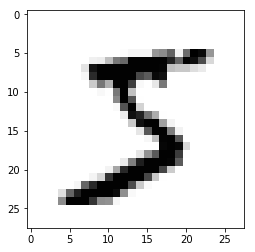

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
import tensorflow as tf
import numpy as np
import math

In [3]:
## reshape X 
image_size = X_train.shape[1]
IMAGE_PIXELS = image_size * image_size

X_train = X_train.reshape((-1, IMAGE_PIXELS)).astype(np.float32)
X_val = X_val.reshape((-1, IMAGE_PIXELS)).astype(np.float32)
X_test = X_test.reshape((-1, IMAGE_PIXELS)).astype(np.float32)

In [4]:
from sklearn.preprocessing import OneHotEncoder
num_labels = 10

enc = OneHotEncoder(n_values = num_labels, sparse=False)
y_train = y_train.reshape((-1,1))
y_val = y_val.reshape((-1,1))
y_test = y_test.reshape((-1,1))
enc.fit(y_train) 

## transfor y to one hot encoding
y_train_labels = enc.transform(y_train)
y_val_labels = enc.transform(y_val)
y_test_labels = enc.transform(y_test)

In [5]:
batch_size = 128 
graph = tf.Graph()
hidden_units = 1024
learning_rate = 0.001


with graph.as_default():   
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size,IMAGE_PIXELS ))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels ))
    tf_valid_dataset = tf.constant(X_val)
    tf_test_dataset = tf.constant(X_test)
    
    with tf.name_scope('hidden'):
        weights = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, hidden_units],stddev=1.0 / math.sqrt(float(hidden_units))), name='weights')
        biases = tf.Variable(tf.zeros([hidden_units]), name='biases')
        hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)
    # Linear
    with tf.name_scope('softmax_linear'):
        linear_weights = tf.Variable(tf.truncated_normal([hidden_units, num_labels]))
        linear_biases = tf.Variable(tf.zeros([num_labels]),name='biases')
        linear_logits = tf.matmul(hidden, linear_weights) + linear_biases
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = linear_logits, labels = tf_train_labels))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    train_prediction = tf.nn.softmax(linear_logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights) + biases), linear_weights) + linear_biases)
    test_prediction =  tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights) + biases), linear_weights) + linear_biases)

In [7]:
num_steps = 4000

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])
loss_list = []
with tf.Session(graph=graph) as session:
  session.run(tf.global_variables_initializer())
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (y_train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = X_train[offset:(offset + batch_size), :]
    batch_labels = y_train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), y_val_labels))
      loss_list.append(l)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), y_test_labels))

Initialized
Minibatch loss at step 0: 5.653521
Minibatch accuracy: 10.2%
Validation accuracy: 38.5%
Minibatch loss at step 500: 0.047718
Minibatch accuracy: 97.7%
Validation accuracy: 94.0%
Minibatch loss at step 1000: 0.086079
Minibatch accuracy: 96.9%
Validation accuracy: 96.2%
Minibatch loss at step 1500: 0.057838
Minibatch accuracy: 96.9%
Validation accuracy: 97.2%
Minibatch loss at step 2000: 0.006843
Minibatch accuracy: 100.0%
Validation accuracy: 97.4%
Minibatch loss at step 2500: 0.020040
Minibatch accuracy: 99.2%
Validation accuracy: 97.8%
Minibatch loss at step 3000: 0.009042
Minibatch accuracy: 100.0%
Validation accuracy: 97.2%
Minibatch loss at step 3500: 0.001961
Minibatch accuracy: 100.0%
Validation accuracy: 97.6%
Test accuracy: 97.3%


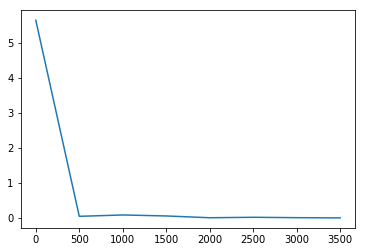

In [14]:
plt.plot(np.arange(0, 4000, 500), loss_list)